In [1]:
import os
import re
import _pickle as cPickle
import gc
import random
from tqdm import tqdm
import numpy as np
import torch

from datasets import load_dataset, load_metric
import math
from itertools import groupby

import wandb

DEVICES=['0','1','2']
BATCH_SIZE = 16

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(DEVICES)
# os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

cache_dir = "/data4/yoomcache"
model_cache_dir = os.path.join(cache_dir, 'huggingfaces')
data_cache_dir = os.path.join(cache_dir, 'datasets')
checkpoint_dir = os.path.join(cache_dir, 'checkpoint')

seed = 0
random.seed(0)
np.random.seed(seed)
torch.manual_seed(seed)

import IPython
import seaborn as sns
sns.set(rc = {'figure.figsize':(16,9)})

In [2]:
from wav2vec2GPTwCTC import *
from configuration_wav2vec2gpt import Wav2Vec2GPTConfig

from transformers import Wav2Vec2FeatureExtractor, GPT2Model
from transformers import GPT2Tokenizer, AddedToken
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [51]:
GPT2Tokenizer.from_pretrained(gpt_pretrained, cache_dir=model_cache_dir)

Offline mode: forcing local_files_only=True
Can't load following files from cache: ['added_tokens_file', 'special_tokens_map_file', 'tokenizer_config_file'] and cannot check if these files are necessary for the tokenizer to operate.
loading file https://huggingface.co/gpt2/resolve/main/vocab.json from cache at /data4/yoomcache/huggingfaces/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f.c7ed1f96aac49e745788faa77ba0a26a392643a50bb388b9c04ff469e555241f
loading file https://huggingface.co/gpt2/resolve/main/merges.txt from cache at /data4/yoomcache/huggingfaces/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598.5d12962c5ee615a4c803841266e9c3be9a691a924f72d395d3a6c6c81157788b
Offline mode: forcing local_files_only=True
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at /data4/yoomcache/huggingfaces/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66

/data4/yoomcache/huggingfaces/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f
/data4/yoomcache/huggingfaces/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598
/data4/yoomcache/huggingfaces/9cd7ab3da379cc8113c67a35c7a14af59be4cf42e1c7afdccc71927d109d5289
/data4/yoomcache/huggingfaces/d4ea4e71d08bfaf81fa2e6e76ff3b9ad18dc2483bd23633076074a989b3fab11
/data4/yoomcache/huggingfaces/b105cf342574b32b2f8d5ea86c4845f46d8162160345fd0c85bd9ca3bc5cc48e
/data4/yoomcache/huggingfaces/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01


PreTrainedTokenizer(name_or_path='gpt2', vocab_size=50257, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True)})

In [3]:
wav2vec_pretrained = "facebook/wav2vec2-base"
# wav2vec_pretrained = "facebook/wav2vec2-base-960h"
gpt_pretrained = "gpt2"

# Should aware that pad_token_id is used to compute CTC loss, 
# so pad_token configuration for both tokenizer and model should be the same
args = {
    
    'pad_token': "<|endoftext|>", 'pad_token_id': 50256,  # 'Ġ' ... 220,
    'unk_token': "<|endoftext|>", 'unk_token_id': 50256,
    'bos_token': "<|endoftext|>", 'bos_token_id': 50256,
    'eos_token': "<|endoftext|>", 'eos_token_id': 50256,
    'ctc_loss_reduction': 'mean',
    
    
    'select_random': True,
    'loss_ver': 'ctc-ce',  # 'ctc-ce', 'ce-ctc', 'ctc', 'ce'
    
    
    'add_adapter': True,
    'num_adapter_layers': 3,
    'output_hidden_size': [128, 256, 512, 256],
    'adapter_kernel_size': [4, 3, 3, 3, 3], 
    'adapter_stride':      [2, 2, 1, 1, 1],
    'adapter_padding':     [4, 0, 0, 0, 0],
    'adapter_bias': False,
    
    
    # Wav2Vec
    'hidden_dropout': 0.0,
    'activation_dropout': 0.0,
    'attention_dropout': 0.0,
    'feat_proj_dropout': 0.0,
    'feat_quantizer_dropout': 0.0,
    'final_dropout': 0.2,
    'layerdrop': 0.0,
    # GPT
    'resid_pdrop': 0.0,
    'embd_pdrop': 0.0,
    'attn_pdrop': 0.0,
    
    
    
}

config = Wav2Vec2GPTConfig(**args)

In [4]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(wav2vec_pretrained, 
                                                             cache_dir=model_cache_dir,
                                                             **args)

tokenizer = GPT2Tokenizer.from_pretrained(gpt_pretrained,
                                          cache_dir=model_cache_dir,
                                          **args)

/data4/yoomcache/huggingfaces/d4583dd9e59eb6295f8fe8b18833ae54d963a122d69aa1df7ecce6caafe18c8f
/data4/yoomcache/huggingfaces/684fe667923972fb57f6b4dcb61a3c92763ad89882f3da5da9866baf14f2d60f
/data4/yoomcache/huggingfaces/c0c761a63004025aeadd530c4c27b860ec4ecbe8a00531233de21d865a402598
/data4/yoomcache/huggingfaces/9cd7ab3da379cc8113c67a35c7a14af59be4cf42e1c7afdccc71927d109d5289
/data4/yoomcache/huggingfaces/d4ea4e71d08bfaf81fa2e6e76ff3b9ad18dc2483bd23633076074a989b3fab11
/data4/yoomcache/huggingfaces/b105cf342574b32b2f8d5ea86c4845f46d8162160345fd0c85bd9ca3bc5cc48e
/data4/yoomcache/huggingfaces/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01


## Dataset

### Data Loading

In [5]:
data_dir = '/data4/TTS/'
data_fname = 'VCTK-Corpus/dataset-vctk-16k.pkl'
# data_fname = 'LibriTTS/train-clean-100.pkl'
# data_fname = 'LibriTTS/dev-clean.pkl'

dataset_ratio = 0.05
#########################################################

with open(os.path.join(data_dir, data_fname), 'rb') as f:
    gc.disable()
    dataset = cPickle.load(f)
    gc.enable()
print('entire dataset length: {}'.format(len(dataset['text'])))


dataset_size = int(len(dataset['text']) * dataset_ratio)
for k in dataset.keys():
    if k == 'sample_rate': continue
    del dataset[k][dataset_size:]
print('dataset length: {}'.format(dataset_size))


min_audio_length, max_audio_length = 1e6, 0
for arr in dataset['audio_array']:
    if len(arr) > max_audio_length:
        max_audio_length = len(arr)
    if len(arr) < min_audio_length:
        min_audio_length = len(arr)
print('maximum audio length: {} ({} sec)'.format(max_audio_length, 
                                                 max_audio_length / dataset['sample_rate']))
print('minimum audio length: {} ({} sec)'.format(min_audio_length, 
                                                 min_audio_length / dataset['sample_rate']))

entire dataset length: 44070
dataset length: 2203
maximum audio length: 213022 (13.313875 sec)
minimum audio length: 23901 (1.4938125 sec)


### Data Example

In [6]:
idx = 11
print('text example: {}'.format(dataset['text'][idx]))
IPython.display.Audio(dataset['audio_array'][idx], rate=16000)

text example: People look, but no one ever finds it.


### Audio Preprocessing w/ `Wav2Vec2FeatureExtractor`

In [7]:
for idx in tqdm(range(dataset_size)):
    dataset['audio_array'][idx] = feature_extractor(dataset['audio_array'][idx], 
                                                    sampling_rate=dataset['sample_rate'],
                                                    return_tensors="pt",
                                                    padding='max_length',
                                                    max_length=max_audio_length
                                                    ).input_values[0]

100%|██████████████████████████████████████| 2203/2203 [00:04<00:00, 532.48it/s]


### Text Prepressing and Tokenizing w/ `GPT2Tokenizer`

In [8]:
_RE_REPLACE_PARENTHESIS = (r'[(){}_\[\]]', '')
_RE_REPLACE_QUESTIONMARK = ('\s\?', '?')
_RE_REPLACE_EXCLAMATIONMARK = ('\s\!', '!')
_RE_REPLACE_DOT = ('\s\.', '.')
_RE_COMBINE_WHITESPACE = (r'\s+', ' ')

re_list = [
    _RE_REPLACE_PARENTHESIS,
    _RE_REPLACE_QUESTIONMARK,
    _RE_REPLACE_EXCLAMATIONMARK,
    _RE_REPLACE_DOT,
    _RE_COMBINE_WHITESPACE, 
]

dataset['retext'] = list()

for txt in dataset['text']:
    retxt = txt
    retxt = retxt.lstrip(' .,?!')
    if retxt[:-1] in ['"', "'"]:
        retxt.strip('\"\'')    
    for pattern, repl in re_list:
        retxt = re.sub(pattern, repl, retxt).strip()
    
    dataset['retext'].append(retxt)
    

In [9]:
dataset['text'] = tokenizer(dataset['retext'],
                            return_tensors="pt",
                            padding='longest'  # VCTK: 42, libritts: 92
                            )

print(dataset['text']['attention_mask'].shape)

torch.Size([2203, 40])


### Generate Custom Dataset

In [10]:
split_ratio = (0.8, 0.9)
indices = np.arange(dataset_size)
np.random.shuffle(indices)

train_idx = indices[:int(dataset_size * split_ratio[0])]
val_idx = indices[int(dataset_size * split_ratio[0]):int(dataset_size * split_ratio[1])]
test_idx = indices[int(dataset_size * split_ratio[1]):]

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_values, tokenized_output, indices):
        self.input_values = input_values
        self.tokenized_output = tokenized_output
        self.indices = indices

    def __getitem__(self, idx):
        item = dict()
        item['input_values'] = self.input_values[self.indices[idx]]
        item['labels'] = self.tokenized_output['input_ids'][self.indices[idx]]
        item['output_attention_mask'] = self.tokenized_output['attention_mask'][self.indices[idx]]
        return item

    def __len__(self):
        return len(self.indices)

    

train_dataset = CustomDataset(dataset['audio_array'], dataset['text'], train_idx)
# val_dataset = CustomDataset(dataset['audio_array'], dataset['text'], val_idx)
val_dataset = CustomDataset(dataset['audio_array'], dataset['text'], train_idx[:dataset_size // 10])
test_dataset = CustomDataset(dataset['audio_array'], dataset['text'], test_idx)

In [12]:
model = Wav2Vec2GPTModel(config=config)

model.wav2vec2 = Wav2Vec2Model2.from_pretrained(wav2vec_pretrained, cache_dir=model_cache_dir, config=config)
model.transformer = GPT2Model.from_pretrained(gpt_pretrained, cache_dir=model_cache_dir, config=config)
model.lm_head.weight = model.transformer.wte.weight


model.freeze_feature_extractor()
# model.freeze_wav2vec_adapter()
# model.freeze_compressor()
model.freeze_gpt_decoder()
model.freeze_lm_head()

/data4/yoomcache/huggingfaces/ef45231897ce572a660ebc5a63d3702f1a6041c4c5fb78cbec330708531939b3


Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2Model2: ['wav2vec2.encoder.layers.7.attention.v_proj.weight', 'wav2vec2.encoder.layers.8.layer_norm.bias', 'wav2vec2.encoder.layers.1.attention.out_proj.weight', 'wav2vec2.encoder.layers.11.attention.k_proj.weight', 'wav2vec2.encoder.layers.9.feed_forward.intermediate_dense.weight', 'wav2vec2.encoder.layers.10.attention.k_proj.weight', 'wav2vec2.encoder.layers.0.attention.q_proj.weight', 'wav2vec2.encoder.layers.0.attention.q_proj.bias', 'wav2vec2.encoder.layers.1.layer_norm.bias', 'wav2vec2.encoder.layers.2.feed_forward.intermediate_dense.bias', 'wav2vec2.encoder.layers.4.attention.k_proj.weight', 'wav2vec2.encoder.layers.4.attention.q_proj.bias', 'wav2vec2.encoder.layers.11.attention.v_proj.weight', 'wav2vec2.encoder.layers.3.feed_forward.intermediate_dense.bias', 'wav2vec2.encoder.layers.6.attention.out_proj.bias', 'wav2vec2.encoder.layers.6.final_layer_norm.bias', 'project_q.bias'

Some weights of Wav2Vec2Model2 were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['wav2vec2.adapter.layers.2.conv.weight', 'wav2vec2.adapter.layers.1.conv.weight', 'wav2vec2.adapter.layers.0.conv.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/data4/yoomcache/huggingfaces/752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e


In [13]:
print(model)

Wav2Vec2GPTModel(
  (wav2vec2): Wav2Vec2Model2(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=Fal

In [14]:
# load rouge for validation
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids_0 = pred.predictions[0].argmax(axis=-1)  # lm_logit_0
    pred_ids_1 = pred.predictions[1].argmax(axis=-1)  # lm_logit_1
    
#     ### only distinct ones
#     pred_ids_0 = [[key for key, _group in groupby(i)] for i in pred_ids_0]  
#     pred_ids_1 = [[key for key, _group in groupby(i)] for i in pred_ids_1]

    ### all unnecessary tokens are removed
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    pred_str_0 = tokenizer.batch_decode(pred_ids_0, skip_special_tokens=True)
    pred_str_1 = tokenizer.batch_decode(pred_ids_1, skip_special_tokens=True)

    rouge_output_0 = rouge.compute(predictions=pred_str_0, references=label_str, 
                                   rouge_types=["rouge2"])['rouge2'].mid
    rouge_output_1 = rouge.compute(predictions=pred_str_1, references=label_str, 
                                   rouge_types=["rouge2"])['rouge2'].mid
    
    return {
        "rouge2_precision_0": round(rouge_output_0.precision, 4),
        "rouge2_recall_0": round(rouge_output_0.recall, 4),
        "rouge2_fmeasure_0": round(rouge_output_0.fmeasure, 4),
        "rouge2_precision": round(rouge_output_1.precision, 4),
        "rouge2_recall": round(rouge_output_1.recall, 4),
        "rouge2_fmeasure": round(rouge_output_1.fmeasure, 4),
    }

In [15]:
### set training arguments - these params are not really tuned, feel free to change ###

steps_per_epoch = math.ceil(len(train_dataset) / BATCH_SIZE / len(DEVICES))

training_args = Seq2SeqTrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=1e-3, 
    weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0,
    num_train_epochs=50,
    max_steps=-1,
    lr_scheduler_type="cosine", 
    
    logging_strategy='steps',
    logging_steps=int(steps_per_epoch / 10),
    evaluation_strategy='epoch',
    eval_steps=1,
    warmup_steps=int(steps_per_epoch * 10),

    output_dir=os.path.join(checkpoint_dir, "wav2vec2gpt/freeze-adapter-rnn"),
    # save_strategy='steps',
    # save_steps=int(steps_per_epoch * 1),
    save_total_limit=3,
    overwrite_output_dir=True,
    
    eval_accumulation_steps=3,

)

In [16]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [17]:
##### start training #####
wandb.init(project="testing-wav2vec2gpt-221123", entity="yoom618") # 2f747faa5c3ba7aa67c3aa9a68f060bf273d26ba
torch.cuda.empty_cache()

trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yoom618. Use `wandb login --relogin` to force relogin


/home/yoomin/anaconda3/envs/py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/home/yoomin/anaconda3/envs/py38/lib/python3.8/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 2. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
***** Running training *****
  Num examples = 1762
  Num Epochs = 50
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 48
  Gradient Accumulat

Epoch,Training Loss,Validation Loss,Rouge2 Precision 0,Rouge2 Recall 0,Rouge2 Fmeasure 0,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,11.377500,21.046621,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,7.284100,28.132736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,6.328400,27.915525,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5.688700,29.786428,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,5.293800,24.780331,0.009100,0.001800,0.003000,0.000000,0.000000,0.000000
6,4.992400,22.545887,0.065200,0.017100,0.026700,0.000000,0.000000,0.000000
7,4.724100,22.625181,0.132600,0.036000,0.053500,0.000000,0.000000,0.000000
8,3.881400,16.954964,0.204100,0.088100,0.116500,0.000200,0.000600,0.000300
9,3.662500,12.525458,0.360900,0.186000,0.231500,0.000900,0.000600,0.000800
10,3.150400,10.703761,0.418800,0.296600,0.336300,0.001100,0.001700,0.001100


***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
***** Running Evaluation *****
  Num examples = 220
  Batch size = 48
Saving model checkpoint to /data4/yoomcache/checkpoint/wav2vec2gpt/freeze-adapter-rnn/chec

KeyboardInterrupt: 

In [18]:
wandb.finish()

eval/loss,▅▇▇█▆▆▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/rouge2_fmeasure,▁▁▁▁▁▁▁▂▄▅▅▁▆█▃▄▄▃▇▃▄▄▆▆█▄▄▄▆▂▄▁▄▅▂▂▁▁▁▁
eval/rouge2_fmeasure_0,▁▁▁▁▁▁▁▂▃▃▄▅▆▆▇▇▇▇██████████████████████
eval/rouge2_precision,▁▁▁▁▁▁▁▂▅▅▄▁▅█▃▃▃▃▅▃▄▃▅▅█▄▄▄▆▂▄▁▅▆▂▂▁▁▁▁
eval/rouge2_precision_0,▁▁▁▁▁▁▂▂▄▄▅▅▆▆▇▇▇▇██████████████████████
eval/rouge2_recall,▁▁▁▁▁▁▁▂▂▄▅▁▇█▃▄▄▅▇▂▅▆▅▆▇▄▃▄▄▂▃▁▃▄▂▂▁▁▁▁
eval/rouge2_recall_0,▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇▇██████████████████████
eval/runtime,█▅▆▄▄▄▄▄▂▂▅▅▄▄▄▃▅▄▄▄▄▄▂▂▂▁▂▁▁▁▂▂▂▁▂▁▁▂▃▁
eval/samples_per_second,▁▃▂▄▅▄▄▄▆▆▃▄▄▄▅▅▄▄▅▅▄▄▇▆▇█▆▇██▆▇▇█▇██▇▆█
eval/steps_per_second,▁▃▂▄▅▄▄▄▆▆▃▄▄▄▅▅▄▄▅▅▄▄▇▆▇█▆▇██▆▇▇█▇██▇▆█
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


In [19]:
!ls /data4/yoomcache/checkpoint/wav2vec2gpt/freeze-adapter-rnn

# model.load_state_dict(torch.load('/data4/yoomcache/checkpoint/wav2vec2gpt/freeze-adapter-rnn/checkpoint-18000/pytorch_model.bin'))

checkpoint-1000  checkpoint-1500  checkpoint-500  runs


In [27]:
##### example


BATCH_SIZE = 4
i = 3
device = 'cuda:0'
batch_idx = train_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]

audio_feature_batch = list()
for idx in batch_idx:
    audio_feature_batch.append(dataset['audio_array'][idx])
audio_feature_batch = torch.stack(audio_feature_batch)

label_batch = dataset['text']['input_ids'][batch_idx]
attention_batch = dataset['text']['attention_mask'][batch_idx]

with torch.no_grad():
    model.eval()
    pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
    pred_ids_0 = pred_logits[0].argmax(dim=-1)
    pred_ids_1 = pred_logits[1].argmax(dim=-1)
    
    for idx in range(BATCH_SIZE):
        print(len([key for key, _group in groupby(label_batch[idx])]))
        print(tokenizer.decode([key for key, _group in groupby(label_batch[idx])]))
        print()
        print(tokenizer.decode([key for key, _group in groupby(pred_ids_0[idx])]))
        print()
        print(tokenizer.decode([key for key, _group in groupby(pred_ids_1[idx])], skip_special_tokens=True))
        print()
        print()


9
Now, that would impress the kids.<|endoftext|>

<|endoftext|>Now,<|endoftext|> that would<|endoftext|> impress<|endoftext|> the<|endoftext|> kids<|endoftext|>.<|endoftext|>

 a
, the
 the
.
.
.


11
I was very pleased with them today, though.<|endoftext|>

<|endoftext|>I was<|endoftext|> very<|endoftext|> pleased<|endoftext|> with them<|endoftext|> today<|endoftext|>, though<|endoftext|>

 a was, the
 the
 the. of to the and


12
Nobody will know the feeling of the branches until October.<|endoftext|>

<|endoftext|>Nobody will<|endoftext|> know<|endoftext|> the<|endoftext|> feeling<|endoftext|> of the<|endoftext|> branches<|endoftext|> until October<|endoftext|>.<|endoftext|>

. the same the same
 the
. the


12
Next league matches, Motherwell - Dundee United.<|endoftext|>

<|endoftext|>Next league<|endoftext|> matches<|endoftext|>,<|endoftext|> Mother<|endoftext|>well<|endoftext|> -<|endoftext|> Dundee<|endoftext|> United<|endoftext|>.<|endoftext|>

., the is,
. the
.,.
 the




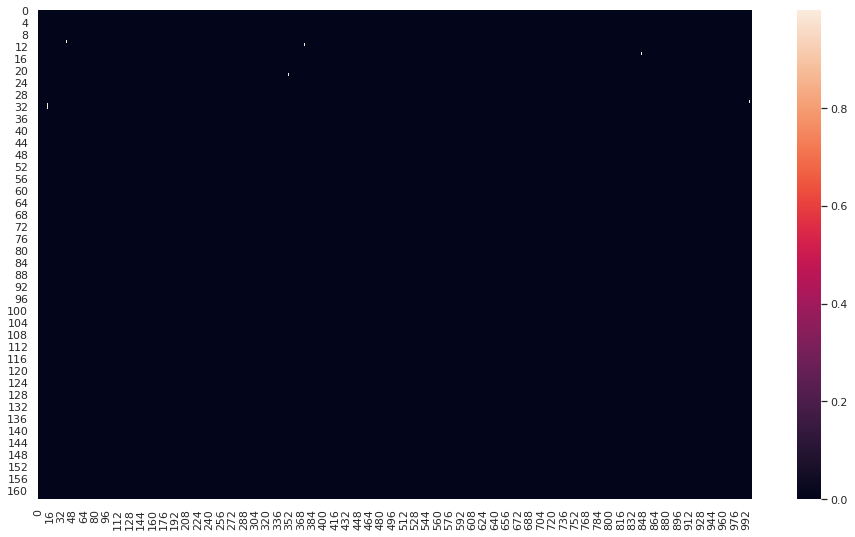

In [21]:
idx = 1

with torch.no_grad():
    model.eval()
    hidden_states_wav = model.wav2vec2(audio_feature_batch.to(device)).last_hidden_state
    hidden_states_wav = model.compressor(hidden_states_wav.transpose(1,2)).transpose(1,2)
    hidden_states_wav = model.attn(hidden_states_wav)
        
    sns.heatmap(
        nn.functional.softmax(model.lm_head(hidden_states_wav), dim=2).cpu()[idx,:, :1000]
    )
    

IPython.display.Audio(dataset['audio_array'][batch_idx[idx]], rate=16000)

In [36]:
word_embeddings_gathered = list()
for i in range(4):
    j = torch.where(pred_ids_0[i] != config.pad_token_id)[0]
    word_embeddings_gathered.append(F.pad(pred_ids_0[i,j], [0,48-len(j)], value=config.pad_token_id))
word_embeddings_gathered = torch.stack(word_embeddings_gathered)

In [52]:
tokenizer.batch_decode(word_embeddings_gathered)

['Now, that would impress the kids.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>',
 'I was very pleased with them today, though<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

In [56]:
(word_embeddings_gathered != config.pad_token_id).long()

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')

## GPT 는 generation용 모델이므로 잘 작동하지 않음.

In [59]:
transformer_outputs = model.transformer(input_ids=word_embeddings_gathered,
                                       attention_mask=(word_embeddings_gathered != config.pad_token_id).long()
                                       )[0]
tokenizer.batch_decode(model.lm_head(transformer_outputs).argmax(dim=-1))

[", I's be me rest.\nTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe",
 '. a happy with the.. and I\n\n\n\n\n\n\n\n\n\nTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe',
 ', be what truth of being people of they,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe',
 ",, are thewell's whoee United -\nTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe"]

In [47]:
tokenizer.batch_decode(model.lm_head(transformer_outputs).argmax(dim=-1))

[", I's be me rest.\nTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe",
 '. a happy with the.. and ITheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe',
 ', be what truth of being people of they,\n\nTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe',
 ",, are thewell's whoee United -\nTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheTheThe"]